In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
referral = pd.read_csv('../data/referral.csv')

In [26]:
referral.head()

,provider_npi,entity_type,provider_org_name,provider_last_name,provider_first_name,provider_middle_name,provider_name_prefix,provider_name_suffix,provider_credential,provider_address_1,...,code_group,provider_code_class,code_display_name,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait,hospital_name,hospital_code_class
0,1003013160,1.0,NaN,GRABENSTEIN,WILLIAM,P.,DR.,NaN,M.D.,1822 MEMORIAL DR,...,Allopathic & Osteopathic Physicians,Family Medicine,Family Medicine Physician,1104202761,32,55,37.891,39.275,Vanderbilt,Internal Medicine
1,1003013160,1.0,NaN,GRABENSTEIN,WILLIAM,P.,DR.,NaN,M.D.,1822 MEMORIAL DR,...,Allopathic & Osteopathic Physicians,Family Medicine,Family Medicine Physician,1104202761,32,55,37.891,39.275,Vanderbilt,Internal Medicine
2,1003019902,1.0,NaN,ACOSTA,LEALANI,MAE,NaN,NaN,MD,3601 TVC,...,Allopathic & Osteopathic Physicians,Psychiatry & Neurology,Neurology Physician,1104202761,261,406,1.495,9.868,Vanderbilt,Internal Medicine
3,1003050972,1.0,NaN,LENTZ,ROBERT,JAMES,DR.,NaN,M.D.,3601 THE VANDERBILT CLINIC,...,Allopathic & Osteopathic Physicians,Internal Medicine,Pulmonary Disease Physician,1104202761,198,317,0.016,0.202,Vanderbilt,Internal Medicine
4,1003052697,2.0,"SUNCREST HEALTHCARE OF EAST TENNESSEE, LLC",NaN,NaN,NaN,NaN,NaN,NaN,117 E BRYANT ST STE C,...,Agencies,Home Health,Home Health Agency,1104202761,133,182,47.769,57.315,Vanderbilt,Internal Medicine


Seems to be a wide variation in average_day_wait, is that an opportunity to poach?
- calculate total days wait per row (average * transactions)
- use new column in groupby for hospital, specialty etc

In [46]:
# top level patient stats by hospital system
# add overall average wait to detect difference at the hospital level (redo, I did it wrong)
top_patient_stats = referral.groupby('hospital_name').agg(total_patients = ('patient_count', 'sum'),
                                                          total_transactions = ('transaction_count', 'sum'),
                                                          total_transaction_wait = ('average_day_wait', 'sum')).reset_index()

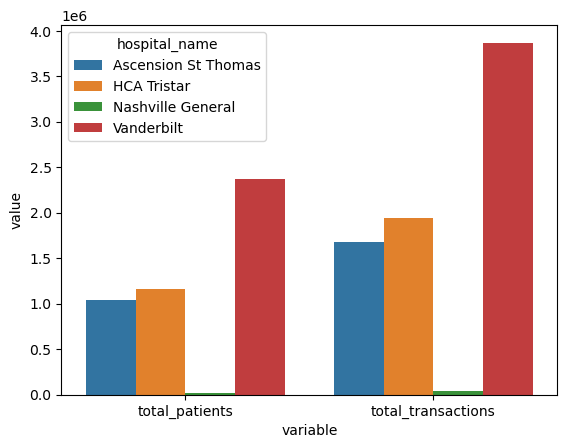

In [40]:
# reshape top patient stats and create grouped barplot

# total patients and transactions by hospital
sns.barplot(
    data = top_patient_stats.melt(id_vars = ['hospital_name'], value_vars = ['total_patients', 'total_transactions']),
    y = 'value', x = 'variable', hue = 'hospital_name', errorbar = None
);

# formatting: remove axis labels, add title, change category and legend names, show actual numbers on y-axis, add counts to bars

In [42]:
# transaction to patient ratio (my understanding is that patients can have multiple referrals so a higher ratio could indicate potential for larger referral gains with less work)
top_patient_stats['patient_transaction_referral'] = top_patient_stats['total_transactions'] / top_patient_stats['total_patients']

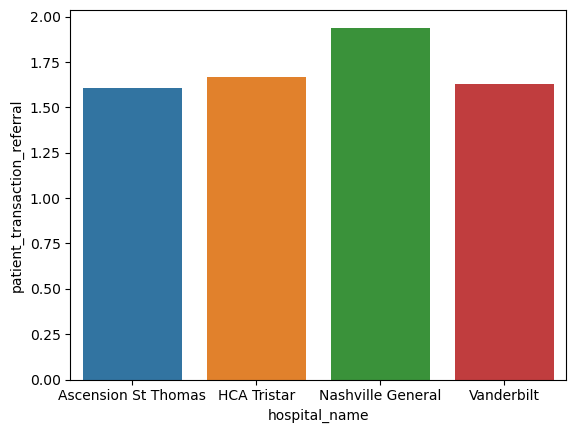

In [44]:
# transactions per patient ratio by hospital
sns.barplot(x = 'hospital_name',
            y = 'patient_transaction_referral',
            data = top_patient_stats);
# formatting: change axis labels, add title, add value number to bars

In [50]:
# calculate average wait by hospital
top_patient_stats['avg_hosp_wait'] = top_patient_stats['total_transaction_wait'] / top_patient_stats['total_transactions']

top_patient_stats

,hospital_name,total_patients,total_transactions,total_transaction_wait,avg_hosp_wait
0,Ascension St Thomas,1045699,1683036,112442.516,0.066809
1,HCA Tristar,1164866,1940550,106227.923,0.054741
2,Nashville General,22118,42906,2936.541,0.068441
3,Vanderbilt,2373032,3871413,305109.016,0.078811


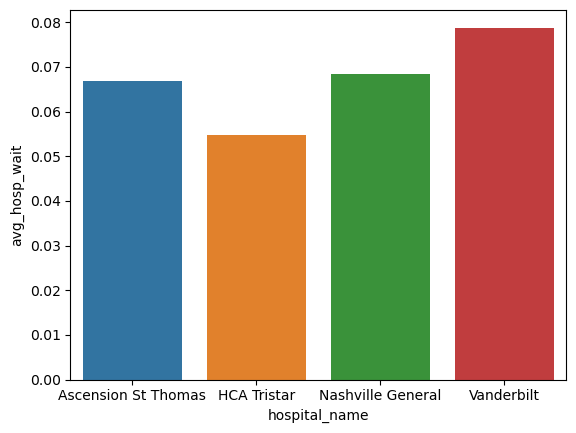

In [51]:
# average days wait by hospital
sns.barplot(x = 'hospital_name',
            y = 'avg_hosp_wait',
            data = top_patient_stats);
# formatting: change axis labels, add title, add value number to bars

In [53]:
# referrals by provider and hospital
# average wait at the provider level could be an indicator of which providers might be more willing to switch (top targets would be most transactions with long wait times)
by_provider = referral.groupby(['hospital_name', 'provider_npi', 'provider_code_class']).agg(total_patients = ('patient_count', 'sum'),
                                                                                             total_transactions = ('transaction_count', 'sum'),
                                                                                             total_transaction_wait = ('average_day_wait', 'sum')).reset_index()

by_provider['avg_hosp_wait'] = by_provider['total_transaction_wait'] / by_provider['total_transactions']

by_provider

,hospital_name,provider_npi,provider_code_class,total_patients,total_transactions,total_transaction_wait,avg_hosp_wait
0,Ascension St Thomas,1003013160,Family Medicine,66,102,58.510,0.573627
1,Ascension St Thomas,1003052697,Home Health,957,1371,467.643,0.341096
2,Ascension St Thomas,1003075862,Family Medicine,138,250,28.272,0.113088
3,Ascension St Thomas,1003076233,Internal Medicine,319,671,6.976,0.010396
4,Ascension St Thomas,1003112277,Nurse Practitioner,140,198,57.656,0.291192
...,...,...,...,...,...,...,...
10276,Vanderbilt,1992904049,Psychiatry & Neurology,218,451,1.675,0.003714
10277,Vanderbilt,1992960298,Radiology,150,162,41.019,0.253204
10278,Vanderbilt,1992972087,Internal Medicine,80,142,69.158,0.487028
10279,Vanderbilt,1992985055,Specialist,49,61,43.459,0.712443


In [54]:
# chart for top 5 referring providers for each hospital system
# partition by_provider by hospital and rank (equivalent in python of course)

In [56]:
# top specialties referring to each hospital and overall

In [57]:
# specialties where Vandy 'underperforms' ie has a lower % of referrals than the overall average

In [58]:
# find providers who send patients to more than just Vanderbilt - they already have a relationship with Vandy so the potential is there to persuade them to send more to Vandy and fewer to others

In [ ]:
# providers who send all patients to other hospitals